# Creating Normalized Master Flats (Bias-Corrected Only)

This notebook:
- Loads the `master_bias.fits`
- For each filter in `flats/`:
  1. Reads all `.fits` images
  2. Subtracts the bias
  3. Combines the corrected images (pixel-by-pixel median)
  4. Normalizes the result by the mean
  5. Saves a `master_flat_<filter>.fits` in `master_flats/`



Darks are **not used** here.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from pathlib import Path

# Folders
flat_root = Path('/Volumes/Astro/ohp/CANAGUIER_LOUSTALET_SAPHORES/20250923/Flats')  # à adapter si besoin
output_dir = Path('master')
output_dir.mkdir(exist_ok=True)

# Master bias
master_bias_path = Path('master_bias.fits')
if not master_bias_path.exists():
    raise FileNotFoundError('master_bias.fits introuvable !')

master_bias = fits.getdata(master_bias_path).astype(np.float32)


Filter g : 20 files
Reading error ._AutoFlat-PANoRot-SDSS_g-Bin1-001-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_g-Bin1-002-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_g-Bin1-003-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_g-Bin1-004-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_g-Bin1-005-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try w

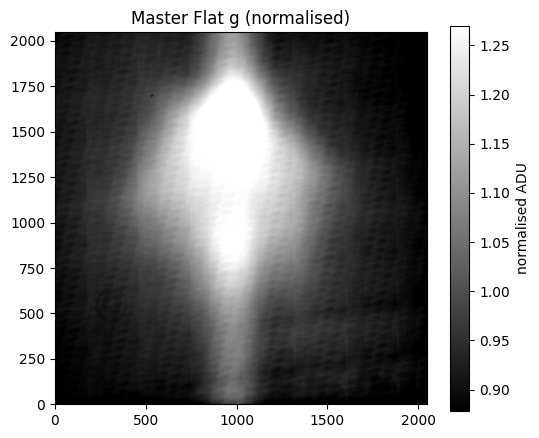

Mean : 1.000 | σ : 0.127
No files  found in /Volumes/Astro/ohp/CANAGUIER_LOUSTALET_SAPHORES/20250923/Flats/i

Filter r : 20 files
Reading error ._AutoFlat-PANoRot-SDSS_r-Bin1-001-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_r-Bin1-002-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_r-Bin1-003-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_r-Bin1-004-NoGEM.fits : No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
Reading error ._AutoFlat-PANoRot-SDSS_r-Bin1-005-NoGEM.fits : 

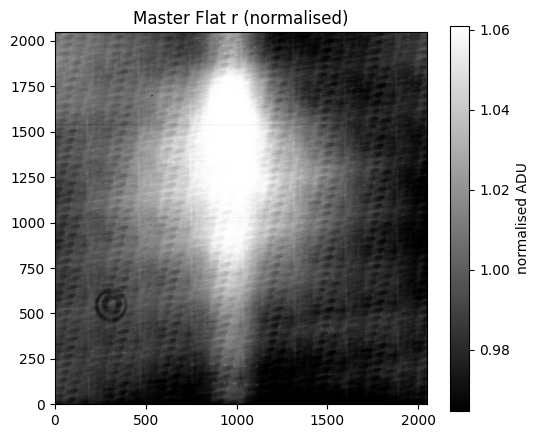

Mean : 1.000 | σ : 0.029


In [12]:
# Process each filter
for subdir in sorted(flat_root.iterdir()):
    if not subdir.is_dir():
        continue

    filter_name = subdir.name
    flat_files = sorted(subdir.glob('*.fits'))
    if len(flat_files) == 0:
        print(f"No files  found in {subdir}")
        continue

    print(f"\nFilter {filter_name} : {len(flat_files)} files")
    flat_data = []

    for file in flat_files:
        try:
            with fits.open(file, ignore_missing_end=True) as hdul:
                data = None
                for hdu in hdul:
                    if hdu.data is not None:
                        data = hdu.data.astype(np.float32)
                        break
                if data is None:
                    continue

                corrected = data - master_bias
                flat_data.append(corrected)

        except Exception as e:
            print(f"Reading error {file.name} : {e}")

    if not flat_data:
        print(f"No fl data for {filter_name}, ignored.")
        continue

    flat_stack = np.array(flat_data)
    master_flat = np.median(flat_stack, axis=0)

    mean_val = np.mean(master_flat)
    master_flat_norm = master_flat / mean_val

    output_file = output_dir / f'master_flat_{filter_name}.fits'
    fits.writeto(output_file, master_flat_norm.astype(np.float32), overwrite=True)
    print(f" Saved: {output_file}")

    plt.figure(figsize=(6,5))
    plt.imshow(master_flat_norm, origin='lower', cmap='gray',
               vmin=np.percentile(master_flat_norm,5), vmax=np.percentile(master_flat_norm,95))
    plt.title(f'Master Flat {filter_name} (normalised)')
    plt.colorbar(label='normalised ADU')
    plt.show()

    print(f"Mean : {np.mean(master_flat_norm):.3f} | σ : {np.std(master_flat_norm):.3f}")